In [ ]:
#uplist[uplist['shcode']=='000080']
#uplist[uplist['shcode']=='000080'].groupby(['shcode']).count()
#tmlist[tmlist['shcode']=='000080']
#tmlist[tmlist['shcode']=='000080'].groupby(['shcode']).count()
#df_bfaf2 = df_bfaf[['index','shcode']].drop_duplicates()

'''
#4-1 분리
s = df['index'].str.split(' ').apply(Series,1)#.fillna(0)
df = pd.merge(df, s,left_index =True, right_index =True ,how = 'left')
df['total_n'] = s.groupby(s.index).count().sum(axis=1)
del df['index']
df = df.fillna(0)
df = pd.merge(df, uplist[['shcode','upcode', 'upname']], how = 'left', on = ['shcode'])
df = pd.merge(df, tmlist[['shcode','tmcode', 'tmname']], how = 'left', on = ['shcode'])
df = pd.merge(df, shcode_list, how = 'left', on = ['shcode'])

df.groupby(['upcode','upname'])['total_n'].count().sort_values(ascending= False)
df.groupby(['tmcode','tmname'])['total_n'].count().sort_values(ascending= False)

li = [x for x in range(0,12)]
df.columns.isin(li)
df2 = df.copy()
for i in df.columns[df.columns.isin(li)]:
    df2[i] = df2[i].str.slice(stop = 6) 
'''

In [1]:
import sqlite3
import time
import pandas as pd
import numpy as np
import query
import preprocesser
import datetime
import pandas.tseries.offsets as of  # for timeoffset
from pandas import Series

In [25]:
#1.종목명
shcode_list = query.query_shcode_list_today()

#2.target from csvs
df = pd.read_csv("high_ratio_0.05_volume_money_20000000000_v4.csv", 
                 dtype ={'shcode':str})
del df['Unnamed: 0']

#3.관련 업종 테마추출
uplist = query.query_up_distinct()
tmlist = query.query_tm_distinct()

#4- 2 분리
t = df['index'].str.split(' ').apply(Series,1).stack()
t.index = t.index.droplevel(-1)
t.name = 'target_day'
del df['index']
df = df.join(t)
df = pd.merge(df, uplist[['shcode','upcode', 'upname']], how = 'left', on = ['shcode'])
df = pd.merge(df, tmlist[['shcode','tmcode', 'tmname']], how = 'left', on = ['shcode'])
df = pd.merge(df, shcode_list, how = 'left', on = ['shcode'])
df['target_m'] = df['target_day'].str.slice(stop = 6)


'\n#5. target day 확인\ntarget_day_list = pd.to_datetime(df[\'target_day\'], format = "%Y-%m-%d")\n\n#(1) for jupo\n#interval calculate before 12 month \ninit_jupo_timestamp = target_day_list + of.MonthEnd(n= -12)\nend_jupo_timestamp = target_day_list\ndf[\'init_jupo\'] = init_jupo_timestamp.apply(lambda x: x.strftime("%Y%m%d"))\ndf[\'end_jupo\'] = end_jupo_timestamp.apply(lambda x: x.strftime("%Y%m%d"))\n'

In [26]:
df.head()

,shcode,target_day,upcode,upname,tmcode,tmname,shname,target_m
0,000080,20190424,1.0,종 합,421.0,日 불매운동 관련주,하이트진로,201904
1,000140,20190708,1.0,종 합,421.0,日 불매운동 관련주,하이트진로홀딩스,201907
2,000140,20190729,1.0,종 합,421.0,日 불매운동 관련주,하이트진로홀딩스,201907
3,000150,20190416,1.0,종 합,111.0,지주사,두산,201904
4,000150,20190726,1.0,종 합,111.0,지주사,두산,201907


In [27]:
#다음 target_day와의 차이 계산
df['next_target_day'] = df['target_day'].shift(-1)
target_day_list = pd.to_datetime(df['target_day'], format = "%Y-%m-%d")
next_target_day_list = pd.to_datetime(df['next_target_day'], format = "%Y-%m-%d")
target_day_diff = next_target_day_list - target_day_list

# 다음 target_day shcode2
df['shcode2'] = df['shcode'].shift(-1)

#label
# 0  : 1 : 한번이상
df['y'] = np.where((df['shcode'] == df['shcode2']) & (target_day_diff <= datetime.timedelta(days = 30)), 1, 0)

In [30]:
%matplotlib inline

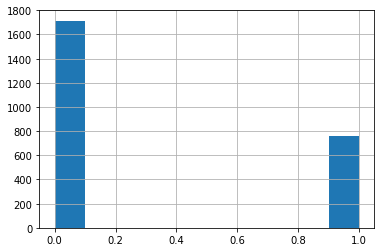

In [31]:
df['y'].hist()

data_preprocessing

In [21]:
#(1) for jupo
#interval calculate before 12 month 
init_jupo_timestamp = target_day_list + of.MonthBegin(n= -12)
end_jupo_timestamp = target_day_list
df['init_jupo'] = init_jupo_timestamp.apply(lambda x: x.strftime("%Y%m%d"))
df['end_jupo'] = end_jupo_timestamp.apply(lambda x: x.strftime("%Y%m%d"))
df = df.reset_index(drop = True)

#(1)-1. 주포관련데이터 구하기
jupo = pd.DataFrame([], columns = ['shcode', 'date', 'max_vol', 'max_jupo','contin_jupo',
                                   'samo_vol_ratio', 'sec_vol_ratio', 'ins_vol_ratio',
                                   'tusin_vol_ratio', 'bank_vol_ratio','jong_vol_ratio', 
                                   'fund_vol_ratio', 'etcom_vol_ratio', 
                                   'for_reg_vol_ratio', 'for_noreg_vol_ratio', 'nat_no_vol_ratio', 
                                   'per_vol_ratio', 'com_vol_ratio', 'for_vol_ratio', 'etc_vol_ratio'])

for i,v in df['shcode'].items:
    
    # 총괄주식수 구하기
    a = query.query_finance(v)
    a['num_total'] = a['total_vol'].astype(int) * 1000

    # 투자자별 매매동향
    b = query.query_jupo_vol(v, fr=df['init_jupo'].iloc[i], to=df['end_jupo'].iloc[i])

    # cumsum index
    c = b.groupby(['shcode','date']).sum().cumsum()
    # multi index to single index
    c = c.reset_index(level=['shcode','date'])

    # calculate max volume
    c_for_value_ratio = c[['samo_vol', 'sec_vol', 'ins_vol', 'tusin_vol', 'bank_vol',
                           'jong_vol', 'fund_vol', 'etcom_vol', 'for_reg_vol', 'for_noreg_vol',
                           'nat_no_vol', 'per_vol', 'com_vol', 'for_vol', 'etc_vol']] / a['num_total'].iloc[0]

    c['max_vol'] = c_for_value_ratio.max(axis=1)
    c['max_jupo'] = c_for_value_ratio.idxmax(axis=1)

    c_for_value_ratio = c_for_value_ratio.rename(columns={'samo_vol' : 'samo_vol_ratio', 'sec_vol' : 'sec_vol_ratio', 
                                      'ins_vol' : 'ins_vol_ratio', 'tusin_vol' : 'tusin_vol_ratio', 'bank_vol' : 'bank_vol_ratio',
                                      'jong_vol' : 'jong_vol_ratio', 'fund_vol' : 'fund_vol_ratio', 'etcom_vol' : 'etcom_vol_ratio',
                                      'for_reg_vol' : 'for_reg_vol_ratio', 'for_noreg_vol' : 'for_noreg_vol_ratio',
                                      'nat_no_vol' : 'nat_no_vol_ratio', 'per_vol' : 'per_vol_ratio', 'com_vol' : 'com_vol_ratio',
                                      'for_vol' : 'for_vol_ratio', 'etc_vol' : 'etc_vol_ratio'})

    c_final = pd.concat([c, c_for_value_ratio], axis=1) # column bind

    jupo_result = c_final.tail(2)
    if jupo_result['max_jupo'].iloc[0] == jupo_result['max_jupo'].iloc[-1]:
        jupo_result['contin_jupo'] = 1
    else: 
        jupo_result['contin_jupo'] = 0

    jupo = jupo.append(jupo_result[['shcode', 'date', 'max_vol', 'max_jupo','contin_jupo','samo_vol_ratio', 'sec_vol_ratio', 'ins_vol_ratio',
                 'tusin_vol_ratio', 'bank_vol_ratio','jong_vol_ratio', 'fund_vol_ratio', 'etcom_vol_ratio', 
                 'for_reg_vol_ratio', 'for_noreg_vol_ratio', 'nat_no_vol_ratio', 
                 'per_vol_ratio', 'com_vol_ratio', 'for_vol_ratio', 'etc_vol_ratio']].iloc[-1])
    


In [ ]:
jupo_result[['shcode', 'date', 'max_vol', 'max_jupo','contin_jupo','samo_vol_ratio', 'sec_vol_ratio', 'ins_vol_ratio',
             'tusin_vol_ratio', 'bank_vol_ratio','jong_vol_ratio', 'fund_vol_ratio', 'etcom_vol_ratio', 
             'for_reg_vol_ratio', 'for_noreg_vol_ratio', 'nat_no_vol_ratio', 
             'per_vol_ratio', 'com_vol_ratio', 'for_vol_ratio', 'etc_vol_ratio']].iloc[-1]

In [24]:
target_day_diff.iloc[1] <= datetime.timedelta(days = 30)

True

In [22]:
(next_target_day_list - target_day_list).iloc[1]

Timedelta('21 days 00:00:00')

In [6]:
target_day_list.iloc[0]

Timestamp('2019-04-24 00:00:00')

In [7]:
target_day_list.iloc[0] - of.DateOffset(n=1)

Timestamp('2019-04-23 00:00:00')

In [4]:
len(df['shcode']), len(df['shcode2'])

In [6]:
df.shape

(2471, 9)

In [16]:
df.head()

,shcode,target_day,upcode,upname,tmcode,tmname,shname,target_m,shcode2,y
0,000080,20190424,1.0,종 합,421.0,日 불매운동 관련주,하이트진로,201904,000140,0
1,000140,20190708,1.0,종 합,421.0,日 불매운동 관련주,하이트진로홀딩스,201907,000140,1
2,000140,20190729,1.0,종 합,421.0,日 불매운동 관련주,하이트진로홀딩스,201907,000150,0
3,000150,20190416,1.0,종 합,111.0,지주사,두산,201904,000150,1
4,000150,20190726,1.0,종 합,111.0,지주사,두산,201907,000230,0


In [7]:
df.tail()

,shcode,target_day,upcode,upname,tmcode,tmname,shname,target_m,shcode2
2466,900340,20191111,NaN,NaN,417.0,아프리카 돼지열병(ASF),윙입푸드,201911,900340
2467,950130,20190822,NaN,NaN,376.0,유전자 치료제/분석,엑세스바이오,201908,900340
2468,950160,20190411,NaN,NaN,NaN,NaN,코오롱티슈진,201904,950130
2469,950170,20190226,NaN,NaN,380.0,면세점,JTC,201902,950160
2470,950170,20190227,NaN,NaN,380.0,면세점,JTC,201902,950170


In [5]:
df.shape

(2463, 8)

In [5]:
df.tail()

,shcode,target_day,upcode,upname,tmcode,tmname,shname,target_m
2466,900340,20191111,NaN,NaN,417.0,아프리카 돼지열병(ASF),윙입푸드,201911
2467,950130,20190822,NaN,NaN,376.0,유전자 치료제/분석,엑세스바이오,201908
2468,950160,20190411,NaN,NaN,NaN,NaN,코오롱티슈진,201904
2469,950170,20190226,NaN,NaN,380.0,면세점,JTC,201902
2470,950170,20190227,NaN,NaN,380.0,면세점,JTC,201902


In [8]:
df

,shcode,target_day,upcode,upname,tmcode,tmname,shname,target_m
0,000080,20190424,1.0,종 합,421.0,日 불매운동 관련주,하이트진로,201904
1,000140,20190708,1.0,종 합,421.0,日 불매운동 관련주,하이트진로홀딩스,201907
2,000140,20190729,1.0,종 합,421.0,日 불매운동 관련주,하이트진로홀딩스,201907
3,000150,20190416,1.0,종 합,111.0,지주사,두산,201904
4,000150,20190726,1.0,종 합,111.0,지주사,두산,201907
5,000230,20191106,1.0,종 합,111.0,지주사,일동홀딩스,201911
6,000300,20190510,1.0,종 합,242.0,탄소나노튜브(CNT),대유플러스,201905
7,000390,20190725,1.0,종 합,330.0,페인트,삼화페인트,201907
8,000400,20190903,1.0,종 합,164.0,손해보험,롯데손해보험,201909
9,000430,20190212,1.0,종 합,386.0,수소차,대원강업,201902


In [15]:
df[df['shcode']=='057030']

,shcode,target_day,upcode,upname,tmcode,tmname,shname,target_m
1354,057030,20181219,303.0,기타 서비스,270.0,모바일콘텐츠(스마트폰/태블릿PC),YBM넷,201812
1355,057030,20181219,303.0,기타 서비스,270.0,모바일콘텐츠(스마트폰/태블릿PC),YBM넷,201812
1356,057030,20181220,303.0,기타 서비스,270.0,모바일콘텐츠(스마트폰/태블릿PC),YBM넷,201812
1357,057030,20181220,303.0,기타 서비스,270.0,모바일콘텐츠(스마트폰/태블릿PC),YBM넷,201812
1358,057030,20190211,303.0,기타 서비스,270.0,모바일콘텐츠(스마트폰/태블릿PC),YBM넷,201902
1359,057030,20190211,303.0,기타 서비스,270.0,모바일콘텐츠(스마트폰/태블릿PC),YBM넷,201902
1360,057030,20190520,303.0,기타 서비스,270.0,모바일콘텐츠(스마트폰/태블릿PC),YBM넷,201905
1361,057030,20190520,303.0,기타 서비스,270.0,모바일콘텐츠(스마트폰/태블릿PC),YBM넷,201905
1362,057030,20190521,303.0,기타 서비스,270.0,모바일콘텐츠(스마트폰/태블릿PC),YBM넷,201905
1363,057030,20190521,303.0,기타 서비스,270.0,모바일콘텐츠(스마트폰/태블릿PC),YBM넷,201905


In [13]:
df[['shcode','shname','target_day']].groupby(['shcode','shname','target_day'])['shcode'].count().sort_values(ascending= False)

shcode  shname    target_day
057030  YBM넷      20190520      2
                  20181220      2
                  20190910      2
                  20190905      2
                  20190521      2
                  20181219      2
                  20190211      2
256840  한국비엔씨     20190821      2
036580  팜스코       20190917      1
036540  SFA반도체    20190814      1
                  20190507      1
                  20190429      1
                  20190423      1
950170  JTC       20190227      1
036200  유니셈       20190314      1
036540  SFA반도체    20190422      1
036480  대성미생물     20190917      1
                  20190531      1
                  20190418      1
                  20190129      1
036580  팜스코       20190925      1
036630  세종텔레콤     20190906      1
036640  HRS       20190916      1
036810  에프에스티     20190212      1
037070  파세코       20190327      1
                  20190326      1
                  20190306      1
037030  파워넷       20190827      1
                  2

In [10]:
df[['shcode','shname','target_day']].drop_duplicates().shape

(2463, 3)

In [8]:
#df.to_excel('11111.xlsx')

In [4]:
df.columns

Index(['shcode', 'target_day', 'upcode', 'upname', 'tmcode', 'tmname',
       'shname', 'target_m'],
      dtype='object')

In [6]:
# 최근
df[df['target_m']=='201911'].groupby(['upcode','upname','target_m'])['shcode'].count().sort_values(ascending= False)

upcode  upname       target_m
320.0   제       약    201911      12
319.0   화       학    201911      10
308.0   유       통    201911       9
307.0   건       설    201911       9
12.0    기       계    201911       9
19.0    운 수 창 고      201911       8
345.0   기술성장 기업      201911       7
315.0   음식료 담배       201911       7
11.0    철 강 금 속      201911       7
324.0   전 기/전 자      201911       6
301.0   코스닥 종합       201911       6
311.0   금       융    201911       5
338.0   오락/문화        201911       5
9.0     의   약  품     201911       5
325.0   의 료/정 밀      201911       5
114.0   KP200 에너지화학  201911       4
16.0    유   통  업     201911       4
4.0     소   형  주     201911       4
304.0   IT   종  합    201911       4
303.0   기타 서비스       201911       3
333.0   컴퓨터서비스       201911       3
26.0    서 비 스 업      201911       3
310.0   운       송    201911       2
316.0   섬 유/의 류      201911       2
317.0   종 이/목 재      201911       2
336.0   반   도  체     201911       2
323.0   기 계 장 비      201911       

In [ ]:
#최소
df[df['upcode']==308].groupby(['upcode','upname'])['target_day'].min().sort_values(ascending= False)
#최대
df[df['upcode']==308].groupby(['upcode','upname'])['target_day'].max().sort_values(ascending= False)

In [7]:
df[df['target_m']=='201911'].groupby(['tmcode','tmname','target_m'])['shcode'].count().sort_values(ascending= False)


tmcode  tmname          target_m
172.0   제약업체            201911      11
377.0   치매 관련주          201911      11
110.0   화장품             201911       7
427.0   구충제(펜벤다졸 등)     201911       6
421.0   日 불매운동 관련주      201911       6
311.0   고령화 사회(노인복지)    201911       6
166.0   항공/저가 항공사(LCC)  201911       6
376.0   유전자 치료제/분석      201911       5
335.0   재난/안전(지진 등)     201911       5
331.0   가상화폐(비트코인 등)    201911       5
387.0   블록체인            201911       5
417.0   아프리카 돼지열병(ASF)  201911       5
27.0    자동차부품           201911       5
171.0   비철금속            201911       4
111.0   지주사             201911       4
33.0    LED             201911       4
149.0   U-HEALTHCARE    201911       4
279.0   스마트폰            201911       4
393.0   갤럭시 부품주         201911       4
401.0   원자력발전소 해체       201911       4
420.0   2019 하반기 신규상장   201911       4
113.0   음식료업종           201911       3
191.0   태양광에너지          201911       3
404.0   폴더블폰            201911       3
128.0   엔터테인먼트          201911 

In [9]:
df.head()

,shcode,target_day,upcode,upname,tmcode,tmname,shname,target_m
0,000080,20190424,1.0,종 합,421.0,日 불매운동 관련주,하이트진로,201904
1,000140,20190708,1.0,종 합,421.0,日 불매운동 관련주,하이트진로홀딩스,201907
2,000140,20190729,1.0,종 합,421.0,日 불매운동 관련주,하이트진로홀딩스,201907
3,000150,20190416,1.0,종 합,111.0,지주사,두산,201904
4,000150,20190726,1.0,종 합,111.0,지주사,두산,201907


In [10]:
#1.종목명
shcode_list = query.query_shcode_list_today()

#2.target from csvs
df = pd.read_csv("high_ratio_0.05_volume_money_20000000000_v4.csv", 
                 dtype ={'shcode':str})

#3. target index 추출
fin_result = pd.DataFrame([],columns = ['target_day','shcode'])

for i,v in df['index'].items():
    shcode = df['shcode'].iloc[i].zfill(6)
    target_date = v.split(" ")
    
    target_day_list = pd.to_datetime(target_date, format = "%Y-%m-%d")
    interval_end_timestamp = target_day_list + datetime.timedelta(weeks=6)
    result = pd.DataFrame(dict(target_day = target_day_list.strftime("%Y%m%d"),
                              interval_end = interval_end_timestamp.strftime("%Y%m%d"))).reset_index()
    del result['index']
    result['shcode'] = shcode
    fin_result = fin_result.append(result)
    
#4. make target month
fin_result['target_m'] = fin_result['target_day'].str.slice(stop = 6)
fin_result = pd.merge(fin_result, shcode_list, how = 'inner', on = 'shcode')

#5. target day 확인
target_day_list = pd.to_datetime(fin_result['target_day'], format = "%Y-%m-%d")

#(1) for jupo
#interval calculate before 12 month 
init_jupo_timestamp = target_day_list + of.MonthEnd(n= -12)
end_jupo_timestamp = target_day_list
fin_result['init_jupo'] = init_jupo_timestamp.apply(lambda x: x.strftime("%Y%m%d"))
fin_result['end_jupo'] = end_jupo_timestamp.apply(lambda x: x.strftime("%Y%m%d"))


fin_result = fin_result[fin_result['target_m']>='201909'].reset_index()
del fin_result['index']
fin_result['index'] = fin_result.index

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [11]:
fin_result.head()

,interval_end,shcode,target_day,target_m,shname,init_jupo,end_jupo,index
0,20191218,000230,20191106,201911,일동홀딩스,20181130,20191106,0
1,20191015,000400,20190903,201909,롯데손해보험,20180930,20190903,1
2,20191108,000885,20190927,201909,한화우,20180930,20190927,2
3,20191017,000890,20190905,201909,보해양조,20180930,20190905,3
4,20191217,001140,20191105,201911,카리스국보,20181130,20191105,4


In [ ]:
pd.merge(df_bfaf2, uplist[['shcode','upcode', 'upname', 'per']], how = 'left', on = ['shcode'])

In [10]:
fin_result.iloc[410:415]

,interval_end,shcode,target_day,target_m,shname,init_jupo,end_jupo,index
410,20191105,078590,20190924,201909,두올산업,20180930,20190924,410
411,20191113,078590,20191002,201910,두올산업,20181031,20191002,411
412,20191216,078860,20191104,201911,아이오케이,20181130,20191104,412
413,20191106,079950,20190925,201909,인베니아,20180930,20190925,413
414,20191227,079960,20191115,201911,동양이엔피,20181130,20191115,414


In [29]:
fin_result[fin_result['shname'] == '켐트로닉스']

,interval_end,shcode,target_day,target_m,shname,init_jupo,end_jupo,index
439,20191227,089010,20191115,201911,켐트로닉스,20181130,20191115,439


In [11]:
fin_result.columns

Index(['interval_end', 'shcode', 'target_day', 'target_m', 'shname',
       'init_jupo', 'end_jupo', 'index'],
      dtype='object')

In [57]:
fin_result['init_jupo'].iloc[439], 

'20181130'

In [73]:
for i in 
    # for jupo query
    a = query.query_jupo_vol(fin_result['shcode'].iloc[439], fr='20181130', to='20191130')
    # cumsum index
    c = a.groupby(['shcode','date']).sum().cumsum()
    # multi index to single index
    c = c.reset_index(level=['shcode','date'])
    # calculate max volume
    c_for_value = c[['samo_vol', 'sec_vol', 'ins_vol', 'tusin_vol', 'bank_vol',
                     'jong_vol', 'fund_vol', 'etcom_vol', 'per_vol', 'for_reg_vol',
                     'for_noreg_vol', 'nat_no_vol', 'com_vol', 'for_vol', 'etc_vol']].tail(1)
    c_for_value.sum(axis=1).iloc[0]

1403282

In [74]:
# for jupo query
a = query.query_jupo_vol(fin_result['shcode'].iloc[439], fr=fin_result['init_jupo'].iloc[439], to='20191231')
# cumsum index
c = a.groupby(['shcode','date']).sum().cumsum()
# multi index to single index
c = c.reset_index(level=['shcode','date'])
# calculate max volume
c_for_value = c[['samo_vol', 'sec_vol', 'ins_vol', 'tusin_vol', 'bank_vol',
                 'jong_vol', 'fund_vol', 'etcom_vol', 'per_vol', 'for_reg_vol',
                 'for_noreg_vol', 'nat_no_vol', 'com_vol', 'for_vol', 'etc_vol']]
c['max_vol'] = c_for_value.max(axis=1)
c['max_jupo'] = c_for_value.idxmax(axis=1)
c = c.assign(max3_sum=np.sum(np.partition(c_for_value.values, -3)[:, -3:], 1))



In [40]:
c.tail()

,shcode,date,samo_vol,sec_vol,ins_vol,tusin_vol,bank_vol,jong_vol,fund_vol,etcom_vol,per_vol,for_reg_vol,for_noreg_vol,nat_no_vol,com_vol,for_vol,etc_vol,max_vol,max_jupo,max3_sum
241,089010,20191125,-710041,-32337,164726,628294,7840,-152048,342360,-12019,-1443628,1204700,2153,0,248794,1206853,-12019,1206853,for_vol,3039847
242,089010,20191126,-726422,-31132,160854,626985,7840,-152048,346014,-11319,-1416555,1193828,1955,0,232091,1195783,-11319,1195783,for_vol,3016596
243,089010,20191127,-782848,-33649,155593,616016,7840,-152048,347014,-13841,-1398161,1252257,1827,0,157918,1254084,-13841,1254084,for_vol,3122357
244,089010,20191128,-791287,-57755,157371,601612,7840,-152048,348599,-3295,-1392433,1279569,1827,0,114332,1281396,-3295,1281396,for_vol,3162577
245,089010,20191129,-757529,-83176,157171,620899,7840,-152048,293159,6385,-1403282,1308754,1827,0,86316,1310581,6385,1310581,for_vol,3240234


In [75]:
c.to_excel("1234.xlsx",encoding = 'ms949')

In [76]:
a = query.query_jupo_vol(fin_result['shcode'].iloc[439], fr=fin_result['init_jupo'].iloc[439], to='20191231')
a.to_excel("1234-1.xlsx",encoding = 'ms949')

In [37]:
b = query.query_finance(fin_result['shcode'].iloc[439])

In [39]:
b.columns

Index(['date', 'shcode', 'close', 'volume', 'volume_money', 'high_52',
       'high_52_day', 'low_52', 'low_52_day', 'rotate_ratio', 'burn_ratio',
       'per', 'total_vol', 'ev_ratio', 'vol_scale', 'market_value'],
      dtype='object')

In [38]:
b['total_vol'].astype(int) * 1000

0    13905000
Name: total_vol, dtype: int32

In [ ]:
13905000 - 4056934

In [56]:
c_sam2 = c[['samo_vol', 'sec_vol', 'ins_vol', 'tusin_vol', 'bank_vol',
           'jong_vol', 'fund_vol', 'etcom_vol', 'per_vol', 'for_reg_vol',
           'for_noreg_vol', 'nat_no_vol', 'com_vol', 'for_vol', 'etc_vol']]
c_sam2.sum(axis=1)

0          768
1         1391
2         4713
3         8197
4         5364
5         5952
6         9889
7         3784
8         4281
9         6685
10        5017
11      -12412
12      -20046
13      -21852
14      -31687
15      -28676
16      -36482
17      -40789
18      -44662
19       14222
20       62999
21       61665
22       68318
23       70326
24       60426
25       55683
26       52569
27       40983
28       34815
29       23644
        ...   
216     209352
217     341543
218     271352
219     510918
220     859740
221     884779
222     897740
223     914734
224     947794
225    1002866
226    1002083
227    1030267
228    1133791
229    1090623
230    1146198
231    1153030
232    1296123
233    1334199
234    1313963
235    1468573
236    1475529
237    1455159
238    1392198
239    1440078
240    1506026
241    1443628
242    1416555
243    1398161
244    1392433
245    1403282
Length: 246, dtype: int64

In [46]:
c_sam = c[['samo_vol', 'sec_vol', 'ins_vol', 'tusin_vol', 'bank_vol',
           'jong_vol', 'fund_vol', 'etcom_vol', 'per_vol', 'for_reg_vol',
           'for_noreg_vol', 'nat_no_vol', 'com_vol', 'for_vol', 'etc_vol']].iloc[245]

In [48]:
c_sam

samo_vol         -757529
sec_vol           -83176
ins_vol           157171
tusin_vol         620899
bank_vol            7840
jong_vol         -152048
fund_vol          293159
etcom_vol           6385
per_vol         -1403282
for_reg_vol      1308754
for_noreg_vol       1827
nat_no_vol             0
com_vol            86316
for_vol          1310581
etc_vol             6385
Name: 245, dtype: int64

In [51]:
c_sam.sum(axis=0)

1403282

In [41]:
# 외인
1310581 / 13905000

0.09425249910104279

In [ ]:
1403282 / 13905000

In [44]:
# 투신
3240234 / 13905000

0.23302653721682848

In [65]:
13905000 - 4056939

9848061

In [67]:
1098523 / 9848061

0.11154713603012817

In [16]:
b = query.query_finance(fin_result['shcode'].iloc[414])

In [17]:
b

,date,shcode,close,volume,volume_money,high_52,high_52_day,low_52,low_52_day,rotate_ratio,burn_ratio,per,total_vol,ev_ratio,vol_scale,market_value
0,20191203,079960,17350,145243,2469,19500,20191119,9000,20190107,15.95,1.85,22.73,7860,40,00001,1348


In [35]:
query.query_finance(fin_result['shcode'].iloc[439])

,date,shcode,close,volume,volume_money,high_52,high_52_day,low_52,low_52_day,rotate_ratio,burn_ratio,per,total_vol,ev_ratio,vol_scale,market_value
0,20191203,089010,16300,440065,7079,18500,20191119,5230,20181226,13.93,3.16,103.49,13905,40,00001,2225


In [23]:
type(b['total_vol'].iloc[0])

str

In [25]:
c.iloc[235]

shcode             079960
date             20191115
samo_vol            48992
sec_vol             99560
ins_vol              1584
tusin_vol           31333
bank_vol           -90339
jong_vol             1224
fund_vol            -1584
etcom_vol           21943
per_vol            229600
for_reg_vol       -329458
for_noreg_vol      -12855
nat_no_vol              0
com_vol             90770
for_vol           -342313
etc_vol             21943
max_vol            229600
max_jupo          per_vol
max3_sum           419930
Name: 235, dtype: object

In [28]:
419930 / 7860000

0.05342620865139949

In [24]:
b['total_vol'].astype(int) * 1000

0    7860000
Name: total_vol, dtype: int32

In [ ]:
'최고가_52','최고가일_52','최저가_52','최저가일_52','소진율','회전율','PER'
'상장주식수_천','증거금율','수량단위',